In [1]:
import utils

2025-02-25 12:08:17.602209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 12:08:17.602282: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 12:08:17.602308: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup config

In [2]:
# from configs.loca_imnet1k_base16 import get_config
from configs.loca_mmearth64_tiny16 import get_config

config = get_config()

## Setup Dataset

In [3]:
from scenic.train_lib import train_utils
import jax.numpy as jnp
import loca_dataset
import ops
import jax

rng = jax.random.key(77)
data_rng, rng = jax.random.split(rng)

dataset = train_utils.get_dataset(config, data_rng)

/home/admin/anaconda3/envs/flax/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2025-02-25 12:08:24.363639: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: meta

### Dataset stats

In [4]:
def remove_batch_dim0(batch, debug=False):
    # Remove dim 0. (Don't know where extra dim is added at 0)
    for k, v in batch.items():
        batch[k] = v.squeeze(0)
        if debug:
            print(f"batch[{k}]: {batch[k].shape}")

    return batch

In [5]:
batch = next(dataset.train_iter)
batch = remove_batch_dim0(batch)
batch = utils.prepare_input(batch, config)

print("mean", batch['reference'].reshape(-1, 12).mean(axis=0))
print("min", batch['reference'].reshape(-1, 12).min(axis=0))
print("max", batch['reference'].reshape(-1, 12).max(axis=0))
print("std", batch['reference'].reshape(-1, 12).std(axis=0))

mean [-0.384689   -0.36719662 -0.38451898 -0.38646322 -0.40820163 -0.41507307
 -0.42880678 -0.44457552 -0.4024879  -0.3478491  -0.3848306  -0.36114895]
min [-0.63840896 -0.6764724  -0.8058472  -0.82409257 -0.953627   -1.2776003
 -1.4149015  -1.5480922  -1.4741229  -1.1811248  -1.5112737  -1.2302656 ]
max [0.74517274 1.3137683  1.3508843  1.1202632  0.92975146 0.91388685
 0.9394878  0.88114667 1.1352582  0.7196159  1.2607524  1.511839  ]
std [0.19177295 0.25942543 0.34245265 0.45129988 0.4192678  0.4607772
 0.51598406 0.5761914  0.5513025  0.49190357 0.6198909  0.6278856 ]


In [6]:
print("mean", batch['query0'].reshape(-1, 12).mean(axis=0))
print("min", batch['query0'].reshape(-1, 12).min(axis=0))
print("max", batch['query0'].reshape(-1, 12).max(axis=0))
print("std", batch['query0'].reshape(-1, 12).std(axis=0))

mean [-0.3965133  -0.3812527  -0.39972332 -0.4027961  -0.42172006 -0.41990796
 -0.4313045  -0.44355854 -0.40088883 -0.34231153 -0.38189068 -0.36672345]
min [-0.6383587  -0.67814636 -0.8061555  -0.8244459  -0.9512701  -1.2592582
 -1.3815607  -1.5141506  -1.4435859  -1.1954477  -1.4951563  -1.2260286 ]
max [0.31914338 0.45808592 0.43012327 0.6637146  0.50387216 0.5614166
 0.7990106  1.0177956  1.0567551  0.8226458  1.0173651  1.2583216 ]
std [0.17198548 0.23017651 0.31855857 0.4335768  0.4047686  0.47217876
 0.53710216 0.60968095 0.5724857  0.52488923 0.61708367 0.6129027 ]


In [7]:
print("mean", batch['queries'].reshape(-1, 12).mean(axis=0))
print("min", batch['queries'].reshape(-1, 12).min(axis=0))
print("max", batch['queries'].reshape(-1, 12).max(axis=0))
print("std", batch['queries'].reshape(-1, 12).std(axis=0))

mean [-0.39854324 -0.38631043 -0.40487814 -0.40887955 -0.42744276 -0.40861446
 -0.41266567 -0.42289254 -0.38646078 -0.32632464 -0.40086874 -0.38147023]
min [-0.63867736 -0.67901367 -0.8075446  -0.82531416 -0.95197904 -1.2733039
 -1.4075925  -1.5424118  -1.4512658  -1.1974965  -1.5096635  -1.2277827 ]
max [0.33809814 0.6092059  0.6045578  0.6690688  0.50480586 0.57076234
 0.97835255 1.1948534  1.2287068  0.9075468  0.9093854  1.1373352 ]
std [0.18414555 0.24108335 0.32548058 0.43616778 0.40706676 0.48876923
 0.56531876 0.6412343  0.6029333  0.5356192  0.6244436  0.6183576 ]


## Visualise data

ValueError: Incompatible shapes for broadcasting: shapes=[(96, 96, 12), (3,)]

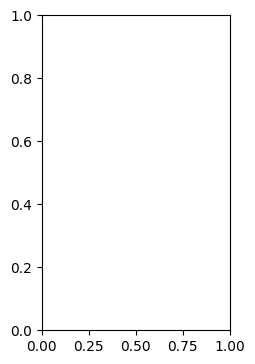

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from configs.loca_imnet1k_base16 import MEAN_RGB, STDDEV_RGB

viz_batch = next(dataset.train_iter)
viz_batch = remove_batch_dim0(viz_batch)
viz_batch = utils.prepare_input(viz_batch, config)

fig = plt.figure(figsize=(17, 9))

gs0 = gridspec.GridSpec(2, 6, figure=fig)

# Plot reference
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[:2, :2])
ref_img = (viz_batch['reference'][0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
ax1.imshow(ref_img)

# Plot queries
n_q_foc = config.dataset_configs.number_of_focal_queries
queries = viz_batch['queries'].reshape(n_q_foc, config.batch_size, 96, 96, 3)
gs01 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs0[1:])
for i, query in enumerate(queries[:4]):
    ax = fig.add_subplot(gs01[0, i])
    ax.imshow(query[0] * jnp.array(STDDEV_RGB) + jnp.array(MEAN_RGB))
    ax.set_title(f'Query {i + 1} Crop')

## Load Model

In [8]:
import flax
from flax.training import checkpoints
import optax
from scenic.train_lib import lr_schedules
import vit
import copy

model = vit.ViTLOCAModel(config, dataset.meta_data)

rng, init_rng = jax.random.split(rng)
(params, _, num_trainable_params, gflops) = train_utils.initialize_model(
    model_def=model.flax_model,
    input_spec=[
        (dataset.meta_data['input_shape'], dataset.meta_data.get('input_dtype', jnp.float32))],
    config=config, rngs=init_rng
)

# Only one model function but two sets of parameters.
ema_params = copy.deepcopy(params)

learning_rate_fn = lr_schedules.get_learning_rate_fn(config)
momentum_parameter_scheduler = lr_schedules.compound_lr_scheduler(
  config.momentum_rate)

weight_decay_mask = jax.tree_util.tree_map(lambda x: x.ndim != 1, params)
tx = optax.inject_hyperparams(optax.adamw)(
  learning_rate=learning_rate_fn, weight_decay=config.weight_decay,
  mask=weight_decay_mask)

opt_state = jax.jit(tx.init, backend='cpu')(params)

chrono = train_utils.Chrono()

train_state = utils.TrainState(
  global_step=0, opt_state=opt_state, tx=tx, params=params,
  ema_params=ema_params, rng=rng, metadata={'chrono': chrono.save()})

# checkpoint_path = "/home/admin/john/scenic/loca_tiny/checkpoint_144001"
# train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

## Run Inference

In [9]:
batch = next(dataset.train_iter)

batch = remove_batch_dim0(batch, debug=True)
batch = utils.prepare_input(batch, config)

batch[query0]: (4, 96, 96, 12)
batch[query0_box]: (4, 5)
batch[query0_mask]: (4, 14, 14, 1)
batch[query1]: (4, 96, 96, 12)
batch[query1_box]: (4, 5)
batch[query1_mask]: (4, 6, 6, 1)
batch[query2]: (4, 96, 96, 12)
batch[query2_box]: (4, 5)
batch[query2_mask]: (4, 6, 6, 1)
batch[query3]: (4, 96, 96, 12)
batch[query3_box]: (4, 5)
batch[query3_mask]: (4, 6, 6, 1)
batch[query4]: (4, 96, 96, 12)
batch[query4_box]: (4, 5)
batch[query4_mask]: (4, 6, 6, 1)
batch[query5]: (4, 96, 96, 12)
batch[query5_box]: (4, 5)
batch[query5_mask]: (4, 6, 6, 1)
batch[query6]: (4, 96, 96, 12)
batch[query6_box]: (4, 5)
batch[query6_mask]: (4, 6, 6, 1)
batch[query7]: (4, 96, 96, 12)
batch[query7_box]: (4, 5)
batch[query7_mask]: (4, 6, 6, 1)
batch[query8]: (4, 96, 96, 12)
batch[query8_box]: (4, 5)
batch[query8_mask]: (4, 6, 6, 1)
batch[query9]: (4, 96, 96, 12)
batch[query9_box]: (4, 5)
batch[query9_mask]: (4, 6, 6, 1)
batch[reference]: (4, 96, 96, 12)


In [10]:
dropout_rng, droptok_rng = jax.random.split(rng)

use_ema = True
drop_moment = "late"

_, r_feat_targets, r_patch_features, _  = model.flax_model.apply(
    {'params': train_state.ema_params if use_ema else params},
    batch['reference'],
    seqlen=config.reference_seqlen,
    seqlen_selection=config.reference_seqlen_selection,
    drop_moment=drop_moment,
    train=True,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng}
)

In [11]:
use_pe = False

q_rand_loc_pred, q_rand_feat_pred, q_rand_patches, q_rand_idx_kept = model.flax_model.apply(
    {'params': params},
    batch['query0'],
    inputs_kv=r_patch_features,
    seqlen=config.query_max_seqlen,
    use_pe=use_pe,
    drop_moment='early',
    train=True,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng})

In [12]:
n_q_foc = config.dataset_configs.number_of_focal_queries

q_foc_loc_pred, q_foc_feat_pred, _, _ = model.flax_model.apply(
    {'params': params},
    batch['queries'],
    inputs_kv=jnp.tile(r_patch_features, (n_q_foc, 1, 1)),
    use_pe=use_pe,
    train=True,
    rngs={'dropout': dropout_rng})

## Analyse model output

### Reference patch tokens

In [12]:
print(r_patch_features.shape)
r_patch_features[0, ::10, :4]

(4, 39, 192)


Array([[ 0.09143923, -1.1700078 , -2.1468859 , -0.1021183 ],
       [ 0.077398  , -1.159975  , -2.163587  , -0.22053656],
       [ 0.09452709, -1.1606191 , -2.1384208 , -0.20092526],
       [ 0.08190839, -1.1760702 , -2.1295161 , -0.16173275]],      dtype=float32)

In [13]:
jnp.any(jnp.isnan(r_patch_features))

Array(False, dtype=bool)

### Query-rand patch tokens

In [13]:
print(q_rand_patches.shape)
q_rand_patches[:2, ::10, :4]

(4, 70, 192)


Array([[[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]]], dtype=float32)

In [27]:
jnp.any(jnp.isnan(q_rand_embs))

Array(False, dtype=bool)

In [28]:
q_rand_embs.shape

(4, 36, 192)

In [15]:
jnp.take(q_rand_embs, q_rand_idx_kept, axis=1, mode='fill')

Array([[[-1.10787064e-01,  8.95349145e-01, -1.33761334e+00, ...,
         -1.89090356e-01, -1.42756999e-01, -9.83212113e-01],
        [-7.92157054e-02,  7.36271799e-01, -1.58569229e+00, ...,
         -3.70677203e-01, -1.69559270e-01, -1.03287411e+00],
        [-1.76383421e-01,  8.34177375e-01, -1.39298892e+00, ...,
         -1.72847956e-01, -9.16181132e-02, -9.49293673e-01],
        ...,
        [ 3.13728154e-02,  1.01889694e+00, -2.27226734e+00, ...,
         -6.61732554e-01, -9.73063558e-02, -1.05954897e+00],
        [-6.09459430e-02,  7.92530179e-01, -1.71518445e+00, ...,
         -3.73998612e-01, -1.72679901e-01, -1.06837070e+00],
        [-8.21409672e-02,  4.87361491e-01, -1.14394379e+00, ...,
         -2.11372897e-01, -1.79671794e-01, -9.07331288e-01]],

       [[ 4.73139733e-02, -4.65126634e-01,  8.14325035e-01, ...,
          8.92506659e-01, -1.52092874e-01,  1.28366202e-01],
        [ 3.23877335e-02, -5.77660680e-01,  8.19554925e-01, ...,
          7.36851156e-01, -1.46330953e

In [13]:
q_rand_embs

Array([[[-1.11150131e-01,  2.81419575e-01,  3.48025441e-01, ...,
          7.11484849e-01,  5.89776397e-01,  1.14823513e-01],
        [ 9.63715762e-02, -7.89189339e-03,  4.70444858e-01, ...,
          6.02702796e-01,  3.53981107e-01, -1.19856268e-01],
        [-1.38252780e-01,  1.78472474e-01,  4.54193890e-01, ...,
          6.85474575e-01,  6.02692604e-01,  1.64564624e-01],
        ...,
        [-2.57698834e-01,  6.14856482e-02,  5.61719656e-01, ...,
          6.70400560e-01,  7.00017452e-01,  1.42730176e-01],
        [-3.18000615e-01,  1.33932084e-02,  6.35494888e-01, ...,
          8.36347580e-01,  6.07930779e-01,  1.02355681e-01],
        [-1.35321662e-01,  2.15220124e-01,  3.44999671e-01, ...,
          7.04621732e-01,  5.89404762e-01, -1.52877614e-01]],

       [[-1.36173427e-01,  2.92362154e-01,  2.63702273e-02, ...,
          9.02320147e-01,  8.81894112e-01, -1.52121991e-01],
        [-2.67507434e-02,  3.85551840e-01, -7.55922794e-02, ...,
          1.03333962e+00,  7.71077573e

### `Q_rand` location targets

In [50]:
q_rand_targets = batch["query0_target_position"]
print(q_rand_targets[0].squeeze(-1))

[[ 65  64  63  62  61  60  58  57  56  -1  -1  -1  -1  -1]
 [ 79  78  77  76  75  74  72  71  70  -1  -1  -1  -1  -1]
 [ 79  78  77  76  75  74  72  71  70  -1  -1  -1  -1  -1]
 [ 93  92  91  90  89  88  86  85  84  -1  -1  -1  -1  -1]
 [107 106 105 104 103 102 100  99  98  -1  -1  -1  -1  -1]
 [121 120 119 118 117 116 114 113 112  -1  -1  -1  -1  -1]
 [121 120 119 118 117 116 114 113 112  -1  -1  -1  -1  -1]
 [135 134 133 132 131 130 128 127 126  -1  -1  -1  -1  -1]
 [149 148 147 146 145 144 142 141 140  -1  -1  -1  -1  -1]
 [163 162 161 160 159 158 156 155 154  -1  -1  -1  -1  -1]
 [177 176 175 174 173 172 170 169 168  -1  -1  -1  -1  -1]
 [177 176 175 174 173 172 170 169 168  -1  -1  -1  -1  -1]
 [191 190 189 188 187 186 184 183 182  -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]]


In [51]:
q_rand_loc_targets = batch['query0_target_position'].reshape(config.batch_size, -1)
q_rand_loc_targets = jnp.take(q_rand_loc_targets, q_rand_idx_kept, axis=1)
q_rand_loc_targets[0][q_rand_loc_targets[0] != -1]

Array([ 90,  92, 183,  77, 190,  72,  70, 132, 189, 141,  79, 105, 149,
       168, 155,  70, 116,  71, 126, 176, 128, 154,  76, 114, 162, 184,
       182, 148, 177, 176,  75,  56, 100,  78, 120, 120, 170,  98],      dtype=int32)

### `q_rand` location predictions

In [54]:
print("q_rand_loc_pred", q_rand_loc_pred.shape)

q_rand_loc_pred[0].argmax(axis=1)

q_rand_loc_pred (4, 70, 36)


Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)